# What drives bond prices? Causality and cointegration

# 1. Import packages


In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import math
from math import exp, sqrt, log
import scipy
import seaborn as sns
import xlsxwriter
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.tsa.stattools as ts
import itertools
import eikon as ek # pip install eikon
import pandas as pd
import numpy as np
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2. Create a Dataframe from Yield Timeseries in Excel

We have previously downloaded the Midyields of 22 Governement bonds (2yr & 10yr) from Eikon using a Python API (as well as the Eikon Excel add-in to double check). These Yields from 01.01.2015 until 30.04.2021 have been saved to the file "MidYields.xlsx"

In [2]:
#reading the excel file into a dataframe and displaying its head

df = pd.read_excel('MidYields.xlsx')
df = df.set_index(['Date']) 
df.head()

,AU10YT=RR,AU2YT=RR,BR10YT=RR,BR2YT=RR,CA10YT=RR,CA2YT=RR,CH10YT=RR,CH2YT=RR,DE10YT=RR,DE2YT=RR,...,SG10YT=RR,SG2YT=RR,TH10YT=RR,TH2YT=RR,TW10YT=RR,TW2YT=RR,US10YT=RR,US2YT=RR,ZA10YT=RR,ZA2YT=RR
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-30,1.697,0.090,9.125,7.030,1.5435,0.3005,-0.2225,-0.776,-0.2010,-0.6890,...,1.588,0.4170,1.67,0.51,NaN,NaN,1.62500,0.16135,9.275,4.675
2021-04-29,1.651,0.089,9.075,7.016,1.5625,0.3105,-0.2120,-0.774,-0.1935,-0.6820,...,1.607,0.4115,1.70,0.51,0.415,0.145,1.64060,0.16315,9.240,4.705
2021-04-28,1.678,0.090,9.075,7.045,1.5290,0.3125,-0.2535,-0.766,-0.2325,-0.6885,...,1.604,0.4140,1.73,0.51,0.420,0.150,1.60935,0.16510,9.200,4.670
2021-04-27,1.681,0.095,9.100,6.995,1.5565,0.3245,-0.2800,-0.751,-0.2530,-0.6935,...,1.597,0.4215,1.70,0.50,0.415,0.150,1.62430,0.18080,NaN,NaN
2021-04-26,1.680,0.087,9.145,6.995,1.5280,0.3225,-0.2795,-0.773,-0.2565,-0.6940,...,1.581,0.4235,1.66,0.52,0.390,0.130,1.56755,0.16870,9.135,4.660


The time series is in inverse order, we can fix this using df.sort_index()

In [3]:
df.sort_index(inplace=True)
df.head()

,AU10YT=RR,AU2YT=RR,BR10YT=RR,BR2YT=RR,CA10YT=RR,CA2YT=RR,CH10YT=RR,CH2YT=RR,DE10YT=RR,DE2YT=RR,...,SG10YT=RR,SG2YT=RR,TH10YT=RR,TH2YT=RR,TW10YT=RR,TW2YT=RR,US10YT=RR,US2YT=RR,ZA10YT=RR,ZA2YT=RR
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,2.8580,2.2095,12.315,12.915,1.7410,0.9985,NaN,NaN,0.4955,-0.1100,...,2.3200,0.6645,NaN,NaN,NaN,NaN,2.11315,0.66660,7.805,6.625
2015-01-05,2.7655,2.1840,12.275,12.825,1.6875,0.9785,0.264,-0.3390,0.5105,-0.1050,...,2.3015,0.6655,2.66,2.105,1.585,0.45,2.03285,0.66270,7.725,6.575
2015-01-06,2.7135,2.1695,12.245,12.695,1.6345,0.9535,0.208,-0.3480,0.4500,-0.1075,...,2.2355,0.6250,2.64,2.085,1.555,0.45,1.93755,0.62500,7.575,6.435
2015-01-07,2.6715,2.1390,12.355,12.675,1.6515,0.9670,0.180,-0.3815,0.4685,-0.1085,...,2.1470,0.6290,2.65,2.085,1.543,0.45,1.96855,0.61505,7.490,6.400


In [4]:
data = df

We drop rows with missing values and check the shape of the dataframe before and after

In [5]:
#drop rows and count how many have been removed
df_clean=pd.DataFrame(data)
df_clean.dropna(axis='rows',inplace=True)

print('table size before cleaning:', df.shape)
print('table size after cleaning:', df_clean.shape)

table size before cleaning: (1665, 44)
table size after cleaning: (1018, 44)


more than 600 rows have been dropped. The reason for this are the various holidays of the respective countries. To overcome this problem we use the backfill method df.bfill() to fill missing values with the previous values.

The resulting clean dataframe seems appropriate to keep working with

In [6]:
#filling missing values with previous values, using backfill method
df_clean = df.bfill()
df_clean.dropna(axis='rows',inplace=True)

print('table size before cleaning:', df.shape)
print('table size after cleaning:', df_clean.shape)

table size before cleaning: (1665, 44)
table size after cleaning: (1664, 44)



for various tests we will need differenced values which is why we create a new dataframe with absolute changes between to points in the time series, using np.diff()


In [7]:
#create df with differenced data
df_diff = pd.DataFrame(df_clean)
df_diff = pd.DataFrame(np.diff(df_diff, axis = 0))
df_diff.columns = df_clean.columns
df_diff

,AU10YT=RR,AU2YT=RR,BR10YT=RR,BR2YT=RR,CA10YT=RR,CA2YT=RR,CH10YT=RR,CH2YT=RR,DE10YT=RR,DE2YT=RR,...,SG10YT=RR,SG2YT=RR,TH10YT=RR,TH2YT=RR,TW10YT=RR,TW2YT=RR,US10YT=RR,US2YT=RR,ZA10YT=RR,ZA2YT=RR
0,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.00,0.00,0.000,0.000,0.00000,0.00000,0.000,0.000
1,-0.0925,-0.0255,-0.040,-0.090,-0.0535,-0.0200,0.0000,0.0000,0.0150,0.0050,...,-0.0185,0.0010,0.00,0.00,0.000,0.000,-0.08030,-0.00390,-0.080,-0.050
2,-0.0520,-0.0145,-0.030,-0.130,-0.0530,-0.0250,-0.0560,-0.0090,-0.0605,-0.0025,...,-0.0660,-0.0405,-0.02,-0.02,-0.030,0.000,-0.09530,-0.03770,-0.150,-0.140
3,-0.0420,-0.0305,0.110,-0.020,0.0170,0.0135,-0.0280,-0.0335,0.0185,-0.0010,...,-0.0885,0.0040,0.01,0.00,-0.012,0.000,0.03100,-0.00995,-0.085,-0.035
4,0.0610,0.0680,-0.035,0.125,0.0510,0.0125,0.0145,0.0000,0.0420,0.0010,...,0.0100,0.0035,0.00,0.00,0.012,0.000,0.04845,-0.00805,-0.085,-0.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,0.0440,0.0020,-0.265,-0.041,0.0025,0.0050,-0.0095,-0.0355,-0.0020,-0.0020,...,0.0095,-0.0230,0.02,0.01,0.005,0.000,0.01790,0.00820,0.080,0.025
1659,-0.0080,0.0000,0.080,-0.030,0.0135,0.0000,0.0105,0.0185,0.0015,0.0020,...,0.0110,0.0260,-0.05,-0.01,-0.025,-0.020,0.00895,0.01020,-0.050,-0.030
1660,0.0010,0.0080,-0.045,0.000,0.0285,0.0020,-0.0005,0.0220,0.0035,0.0005,...,0.0160,-0.0020,0.04,-0.02,0.025,0.020,0.05675,0.01210,0.065,0.010
1661,-0.0030,-0.0050,-0.025,0.050,-0.0275,-0.0120,0.0265,-0.0150,0.0205,0.0050,...,0.0070,-0.0075,0.03,0.01,0.005,0.000,-0.01495,-0.01570,0.000,0.000


# Running initial analysis and tests on the data

Check if there are missing values

In [8]:
#lets check if there are missing values
df_clean.isnull().sum()

AU10YT=RR    0
AU2YT=RR     0
BR10YT=RR    0
BR2YT=RR     0
CA10YT=RR    0
CA2YT=RR     0
CH10YT=RR    0
CH2YT=RR     0
DE10YT=RR    0
DE2YT=RR     0
DK10YT=RR    0
DK2YT=RR     0
ES10YT=RR    0
ES2YT=RR     0
FI10YT=RR    0
FI2YT=RR     0
FR10YT=RR    0
FR2YT=RR     0
GB10YT=RR    0
GB2YT=RR     0
IN10YT=RR    0
IN2YT=RR     0
IT10YT=RR    0
IT2YT=RR     0
JP10YT=RR    0
JP2YT=RR     0
PL10YT=RR    0
PL2YT=RR     0
PT10YT=RR    0
PT2YT=RR     0
RU10YT=RR    0
RU2YT=RR     0
SE10YT=RR    0
SE2YT=RR     0
SG10YT=RR    0
SG2YT=RR     0
TH10YT=RR    0
TH2YT=RR     0
TW10YT=RR    0
TW2YT=RR     0
US10YT=RR    0
US2YT=RR     0
ZA10YT=RR    0
ZA2YT=RR     0
dtype: int64

In [9]:
df_clean.describe()

,AU10YT=RR,AU2YT=RR,BR10YT=RR,BR2YT=RR,CA10YT=RR,CA2YT=RR,CH10YT=RR,CH2YT=RR,DE10YT=RR,DE2YT=RR,...,SG10YT=RR,SG2YT=RR,TH10YT=RR,TH2YT=RR,TW10YT=RR,TW2YT=RR,US10YT=RR,US2YT=RR,ZA10YT=RR,ZA2YT=RR
count,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,...,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000
mean,2.102229,1.418672,10.322150,8.934950,1.516025,1.007457,-0.281472,-0.872016,0.109223,-0.597438,...,1.966416,1.189386,2.167864,1.423293,0.877239,0.434909,2.006921,1.240395,8.737753,6.802221
std,0.727301,0.687858,2.616039,3.642729,0.508722,0.638725,0.250482,0.112691,0.413215,0.174835,...,0.520678,0.528401,0.542789,0.440176,0.326249,0.142145,0.666196,0.827543,0.590571,1.043446
min,0.592500,0.073000,6.250000,3.130000,0.433000,0.146000,-1.149000,-1.405500,-0.859000,-1.017000,...,0.676500,0.188500,0.820000,0.430000,0.255000,0.090000,0.511000,0.104200,6.770000,3.915000
25%,1.326250,0.797125,7.875000,5.857500,1.224000,0.484250,-0.479875,-0.940500,-0.298500,-0.707500,...,1.734875,0.886500,1.693750,1.350000,0.662500,0.360000,1.661000,0.631037,8.410000,6.458750
50%,2.442750,1.763000,10.102500,8.166250,1.516500,0.720750,-0.242750,-0.856000,0.223250,-0.643000,...,2.093500,1.198250,2.370000,1.515000,0.863000,0.465000,2.121450,1.178925,8.707500,7.035000
75%,2.693625,1.952250,12.155000,12.410000,1.868250,1.597625,-0.091875,-0.793000,0.431125,-0.548750,...,2.353625,1.615000,2.620000,1.725000,1.055375,0.540000,2.433500,1.820537,9.081250,7.525000
max,3.145000,2.209500,16.830000,17.005000,2.598000,2.355500,0.264000,-0.339000,0.987000,-0.105000,...,2.867000,2.112500,3.105000,2.135000,1.655000,1.620000,3.238250,2.971150,12.340000,9.000000


Boxplotting yield means

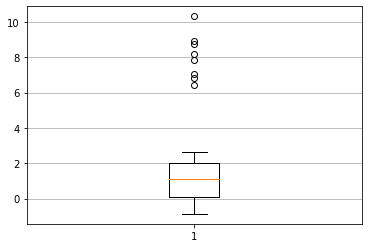

Median 			1.129
Lower Quartile 		0.088
Upper Quartile 		2.031
Minimum 		-0.872
Maximum 		2.645


In [11]:
bplot = plt.boxplot(df_clean.mean(), showfliers = True)
plt.grid(axis = 'y')
plt.show()
whiskers = [item.get_ydata()[1] for item in bplot['whiskers']]
median = np.median(df_clean.mean())
upper_quartile = np.percentile(df_clean.mean(), 75)
lower_quartile = np.percentile(df_clean.mean(), 25)
print('Median \t\t\t' + str("%.3f" %median))
print('Lower Quartile \t\t' + str("%.3f" %lower_quartile))
print('Upper Quartile \t\t' + str("%.3f" %upper_quartile))
print('Minimum \t\t' + str("%.3f" %whiskers[0]))
print('Maximum \t\t' + str("%.3f" %whiskers[1]))

Identifying outliers

In [12]:
dfmean = df_clean.describe()
columns = dfmean.columns
for col in columns:
    if dfmean[col].iloc[1] > 5:
        print(str(col) + "\t " +str("%.3f" % dfmean[col].iloc[1]))

BR10YT=RR	 10.322
BR2YT=RR	 8.935
IN10YT=RR	 7.026
IN2YT=RR	 6.415
RU10YT=RR	 8.171
RU2YT=RR	 7.854
ZA10YT=RR	 8.738
ZA2YT=RR	 6.802


Plotting time series to check for anomalies

In [10]:
data_clean = df_clean
for col in data_clean.iteritems():
    print('plotting'+col[0])
    fig, ax = plt.subplots()
    indicator=data_clean[col[0]]
    ax.plot(indicator, alpha=0.9, color='blue')
    plt.title(col[0])
    plt.savefig('Charts\Plot_'+col[0]+'.png')
    plt.close()

plottingAU10YT=RR
plottingAU2YT=RR
plottingBR10YT=RR
plottingBR2YT=RR
plottingCA10YT=RR
plottingCA2YT=RR
plottingCH10YT=RR
plottingCH2YT=RR
plottingDE10YT=RR
plottingDE2YT=RR
plottingDK10YT=RR
plottingDK2YT=RR
plottingES10YT=RR
plottingES2YT=RR
plottingFI10YT=RR
plottingFI2YT=RR
plottingFR10YT=RR
plottingFR2YT=RR
plottingGB10YT=RR
plottingGB2YT=RR
plottingIN10YT=RR
plottingIN2YT=RR
plottingIT10YT=RR
plottingIT2YT=RR
plottingJP10YT=RR
plottingJP2YT=RR
plottingPL10YT=RR
plottingPL2YT=RR
plottingPT10YT=RR
plottingPT2YT=RR
plottingRU10YT=RR
plottingRU2YT=RR
plottingSE10YT=RR
plottingSE2YT=RR
plottingSG10YT=RR
plottingSG2YT=RR
plottingTH10YT=RR
plottingTH2YT=RR
plottingTW10YT=RR
plottingTW2YT=RR
plottingUS10YT=RR
plottingUS2YT=RR
plottingZA10YT=RR
plottingZA2YT=RR


Creating Heatmaps for 2yr and 10yr yields

In [13]:
df2yr = df_clean.filter(like='2Y', axis=1)
df10yr = df_clean.filter(like='10Y', axis=1)

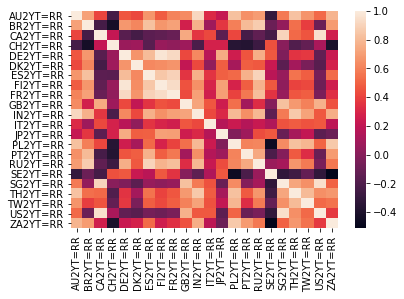

In [14]:
corr2yr = df2yr.corr()
sns.heatmap(corr2yr, 
            xticklabels=corr2yr.columns.values,
            yticklabels=corr2yr.columns.values)

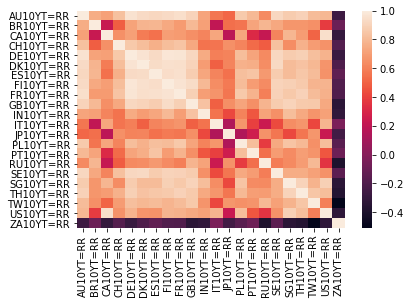

In [15]:
corr10yr = df10yr.corr()
sns.heatmap(corr10yr, 
            xticklabels=corr10yr.columns.values,
            yticklabels=corr10yr.columns.values)

In [16]:
df_clean.corr()

,AU10YT=RR,AU2YT=RR,BR10YT=RR,BR2YT=RR,CA10YT=RR,CA2YT=RR,CH10YT=RR,CH2YT=RR,DE10YT=RR,DE2YT=RR,...,SG10YT=RR,SG2YT=RR,TH10YT=RR,TH2YT=RR,TW10YT=RR,TW2YT=RR,US10YT=RR,US2YT=RR,ZA10YT=RR,ZA2YT=RR
AU10YT=RR,1.000000,0.931766,0.753017,0.738326,0.715039,0.243626,0.830162,-0.194828,0.960741,0.462926,...,0.874285,0.398993,0.898282,0.684590,0.816492,0.537614,0.793672,0.368115,-0.263487,0.695914
AU2YT=RR,0.931766,1.000000,0.715261,0.711841,0.725194,0.408884,0.691079,-0.238944,0.907959,0.462984,...,0.896648,0.575014,0.874010,0.837075,0.812507,0.666094,0.826435,0.525550,-0.336822,0.785135
BR10YT=RR,0.753017,0.715261,1.000000,0.963870,0.232183,-0.194958,0.486895,-0.341715,0.719460,0.650817,...,0.675380,0.063719,0.670274,0.506485,0.656055,0.311580,0.386374,-0.048729,-0.093793,0.668001
BR2YT=RR,0.738326,0.711841,0.963870,1.000000,0.204973,-0.237000,0.431288,-0.426064,0.697060,0.679936,...,0.683804,0.047474,0.680860,0.542503,0.721289,0.389648,0.369453,-0.097342,-0.222523,0.687453
CA10YT=RR,0.715039,0.725194,0.232183,0.204973,1.000000,0.806419,0.654140,0.097612,0.708913,0.132822,...,0.791154,0.812999,0.697038,0.675275,0.505953,0.580431,0.952716,0.830698,-0.301572,0.484989
CA2YT=RR,0.243626,0.408884,-0.194958,-0.237000,0.806419,1.000000,0.214303,0.215646,0.269043,-0.167120,...,0.451442,0.906024,0.292206,0.526973,0.098565,0.459082,0.725833,0.958312,-0.197391,0.261495
CH10YT=RR,0.830162,0.691079,0.486895,0.431288,0.654140,0.214303,1.000000,0.222580,0.862442,0.469525,...,0.644982,0.238755,0.773773,0.453227,0.697009,0.378574,0.661624,0.290291,-0.174667,0.332238
CH2YT=RR,-0.194828,-0.238944,-0.341715,-0.426064,0.097612,0.215646,0.222580,1.000000,-0.084803,0.068413,...,-0.196951,0.009178,-0.146662,-0.188678,-0.215419,-0.128636,-0.028156,0.121549,0.135503,-0.406471
DE10YT=RR,0.960741,0.907959,0.719460,0.697060,0.708913,0.269043,0.862442,-0.084803,1.000000,0.570812,...,0.870421,0.404888,0.889884,0.650984,0.828770,0.553049,0.778251,0.375573,-0.284118,0.647172
DE2YT=RR,0.462926,0.462984,0.650817,0.679936,0.132822,-0.167120,0.469525,0.068413,0.570812,1.000000,...,0.464639,-0.024342,0.493123,0.354012,0.663710,0.369456,0.211523,-0.133949,-0.387491,0.234252


# Durbin Watson Test

Durbin WatsonTest; used to detect the presence of autocorrelation in the residuals of a regression  
The null hypothesis of the test is that there is no serial correlation

For r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will
always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [17]:
from statsmodels.stats.stattools import durbin_watson
var_list = df_clean.columns

for i in var_list:
    dw = durbin_watson(df_clean[i])    
    dw_diff = durbin_watson(np.diff(df_clean[i]))
    print('Durbin_Watson \t\t ' + i + ':\t' + str("%.3f" %dw))
    print('Durbin_Watson_diff \t ' + i + ':\t' + str("%.3f" %dw_diff)+'\n')

Durbin_Watson 		 AU10YT=RR:	0.000
Durbin_Watson_diff 	 AU10YT=RR:	1.991

Durbin_Watson 		 AU2YT=RR:	0.000
Durbin_Watson_diff 	 AU2YT=RR:	2.033

Durbin_Watson 		 BR10YT=RR:	0.000
Durbin_Watson_diff 	 BR10YT=RR:	2.185

Durbin_Watson 		 BR2YT=RR:	0.000
Durbin_Watson_diff 	 BR2YT=RR:	2.062

Durbin_Watson 		 CA10YT=RR:	0.001
Durbin_Watson_diff 	 CA10YT=RR:	2.023

Durbin_Watson 		 CA2YT=RR:	0.001
Durbin_Watson_diff 	 CA2YT=RR:	1.853

Durbin_Watson 		 CH10YT=RR:	0.006
Durbin_Watson_diff 	 CH10YT=RR:	1.920

Durbin_Watson 		 CH2YT=RR:	0.001
Durbin_Watson_diff 	 CH2YT=RR:	2.314

Durbin_Watson 		 DE10YT=RR:	0.007
Durbin_Watson_diff 	 DE10YT=RR:	1.944

Durbin_Watson 		 DE2YT=RR:	0.001
Durbin_Watson_diff 	 DE2YT=RR:	2.023

Durbin_Watson 		 DK10YT=RR:	0.006
Durbin_Watson_diff 	 DK10YT=RR:	1.922

Durbin_Watson 		 DK2YT=RR:	0.002
Durbin_Watson_diff 	 DK2YT=RR:	2.015

Durbin_Watson 		 ES10YT=RR:	0.001
Durbin_Watson_diff 	 ES10YT=RR:	1.950

Durbin_Watson 		 ES2YT=RR:	0.005
Durbin_Watson_diff 	 ES2YT=RR:

# Variance Inflation Factor Test

VIF = 1 → No correlation

VIF = 1 to 5 → Moderate correlation

VIF >10 → High correlation

In [18]:
#non-differenced data

vif = pd.DataFrame()
vif["variables"] = df_clean.columns
vif["VIF"] = [variance_inflation_factor(df_clean.values, i) for i in range(df_clean.shape[1])]
    
vif

,variables,VIF
0,AU10YT=RR,2718.791624
1,AU2YT=RR,1158.644724
2,BR10YT=RR,1061.805992
3,BR2YT=RR,960.177238
4,CA10YT=RR,2221.854506
5,CA2YT=RR,861.064533
6,CH10YT=RR,70.606233
7,CH2YT=RR,322.580263
8,DE10YT=RR,349.908991
9,DE2YT=RR,1322.082408


In [19]:
#differentiated data

vifdiff = pd.DataFrame()
vif["variables"] = df_diff.columns
vif["VIF"] = [variance_inflation_factor(df_diff.values, i) for i in range(df_diff.shape[1])]
    
vif

,variables,VIF
0,AU10YT=RR,3.408439
1,AU2YT=RR,2.587403
2,BR10YT=RR,1.512148
3,BR2YT=RR,1.474697
4,CA10YT=RR,7.489189
5,CA2YT=RR,3.723568
6,CH10YT=RR,2.381840
7,CH2YT=RR,1.248326
8,DE10YT=RR,10.429573
9,DE2YT=RR,3.943186


# ADF: Augmented Dickey Fuller Test

- Testing the non-differenced data for 1 up to 2 lags
- Testing the differenced data for 1 up to 2 lags


In [18]:
#create df for 1 lag data
df_lag_1 = pd.DataFrame(dtype = 'object',index = ["Stat", "P-Value", "Lags", "Nb of Obs", "CritValues"])

for i in var_list:
    #for lags in range(1,3):
        #print('Number of lags used:',lags)

        adf_library = adfuller(df_clean[i], maxlag=1, regression='nc',autolag=None)
        df_lag_1[i] = adf_library

#Values adf_library[4] for row "CritValues" are dictionaries. Therefore we append rows for each key and its value
crit_values = adf_library[4]

for key in crit_values:
    df_lag_1 = df_lag_1.append(pd.Series(dtype = 'object',name = key))
    df_lag_1.loc[key] = [crit_values[key]]

#we can now drop the old row "CritValues"    
df_lag_1 = df_lag_1.drop("CritValues")  